In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

实验设计：
- 从 Visium 删除一部分 spot，这些 spot 作为验证集。
- 将 dropped Visium 输入 iStar 进行超分，采用 VisiumHD 模式 8um super pixel size
- 将验证集 spot 所覆盖的像素加和作为预测值
- 计算 pcc, mse

## 一、数据准备

In [2]:
from datasets import VisiumData, VisiumHDData
from models import iStar
from pathlib import Path
from profiles import VisiumProfile, VisiumHDProfile
import imageio.v2 as ii
import cv2
import random
import matplotlib.pyplot as plt

### 1.1 删除一部分 spot
数据集：DLPFC

In [3]:
visium_path = Path('/home/yiriso/Research/Super-resolvedST/data/DLPFC/sample_151673')
raw_visium = VisiumData()
visium_profile = VisiumProfile(slide_serial=1)
raw_visium.load(
    path=visium_path,
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
raw_visium.select_HVG(n_top_genes=2000,min_counts=10)

Start load
Finish load in 0.4177 s


随机删除 spot

In [4]:
random.seed(2357)
drop_ids = random.sample(range(len(visium_profile)), 1000)
dropped_visium = raw_visium.drop_spots(spot_ids=drop_ids, in_place=False)

738 spots will be dropped.


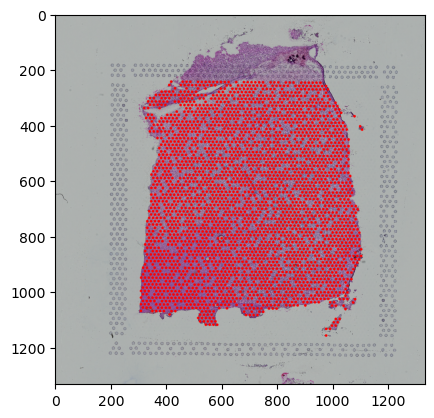

In [5]:
spot_img = dropped_visium.vision_spots(in_tissue=True)
plt.imshow(cv2.resize(spot_img, None, fx=0.1, fy=0.1))

将删除 spot 的数据保存成 Visium 原始格式用于超分。

In [6]:
dropped_visium.save("DLPFC_dropped")

Start save
Finish save in 1.3725 s


将数据保存 anndata 的 h5ad 格式用于分析。

In [7]:
raw_adata = raw_visium.to_anndata()
raw_adata

AnnData object with n_obs × n_vars = 4992 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial'
    obsm: 'spatial'

In [8]:
dropped_adata = dropped_visium.to_anndata()
dropped_adata

AnnData object with n_obs × n_vars = 4992 × 2000
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
raw_adata.write_h5ad("raw_DLPFC.h5ad")
dropped_adata.write_h5ad("dropped_DLPFC.h5ad")

### 1.2 使用 iStar 超分

使用 VisiumHD 模式，tissue_positions 保存了配置信息

这里设置了相较于 VisiumHD 更大的测序范围，否则将警告提示 spot 覆盖了超出 visiumHD 测序范围的 bin。

In [10]:
visiumHD_profile = VisiumHDProfile(bin_size=8,row_range = 3500,col_range = 3500)
# visiumHD_profile = VisiumHDProfile(bin_size=8)
visiumHD_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col
0,0,s_008um_00000_00000-1,0,0,4.0,4.0
1,1,s_008um_00000_00001-1,0,1,4.0,12.0
2,2,s_008um_00000_00002-1,0,2,4.0,20.0
3,3,s_008um_00000_00003-1,0,3,4.0,28.0
4,4,s_008um_00000_00004-1,0,4,4.0,36.0
...,...,...,...,...,...,...
765620,765620,s_008um_00874_00870-1,874,870,6996.0,6964.0
765621,765621,s_008um_00874_00871-1,874,871,6996.0,6972.0
765622,765622,s_008um_00874_00872-1,874,872,6996.0,6980.0
765623,765623,s_008um_00874_00873-1,874,873,6996.0,6988.0


读取构建的 dropped 数据，设置遮掩，生成 VisiumHD 结果半成品（缺乏表达量信息）

In [11]:
# visium_profile = VisiumProfile(slide_serial=1)
# visium_path = Path('/home/yiriso/Research/Super-resolvedST/data/DLPFC/sample_151673')
istar_visium = iStar()
istar_visium.load(
    path="DLPFC_dropped",
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
istar_visium.tissue_mask(mask_image_path=visium_path/"mask.png")
visiumHD_demo = istar_visium.Visium2HD(visiumHD_profile)

Start load
Finish load in 0.1707 s


Visium 和 VisiumHD 的配置中可以得到具体信息 spot-bin 覆盖关系

In [12]:
visium_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col,pxl_row_in_fullres,pxl_col_in_fullres,num_bin_in_spot,num_bin_out_spot
0,0,ACGCCTGACACGCGCT-1,0,0,27.500000,27.5,2427,2811,39,0
1,1,TACCGATCCAACACTT-1,1,1,114.102540,77.5,2547,2879,38,0
2,2,ATTAAAGCGGACGAGC-1,0,2,27.500000,127.5,2428,2949,36,0
3,3,GATAAGGGACGATTAG-1,1,3,114.102540,177.5,2548,3017,37,0
4,4,GTGCAAATCACCAATA-1,0,4,27.500000,227.5,2429,3086,39,0
...,...,...,...,...,...,...,...,...,...,...
4987,4987,GAACGTTTGTATCCAC-1,77,123,6695.895609,6177.5,11713,11214,39,0
4988,4988,ATTGAATTCCCTGTAG-1,76,124,6609.293069,6227.5,11594,11283,37,0
4989,4989,TACCTCACCAATTGTA-1,77,125,6695.895609,6277.5,11714,11351,36,0
4990,4990,AGTCGAATTAGCGTAA-1,76,126,6609.293069,6327.5,11595,11421,38,0


In [13]:
visiumHD_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col,spot_label,pxl_row_in_fullres,pxl_col_in_fullres
0,0,s_008um_00000_00000-1,0,0,4.0,4.0,0,2199.586629,2370.563834
1,1,s_008um_00000_00001-1,0,1,4.0,12.0,0,2199.666242,2381.580786
2,2,s_008um_00000_00002-1,0,2,4.0,20.0,0,2199.745854,2392.597737
3,3,s_008um_00000_00003-1,0,3,4.0,28.0,0,2199.825467,2403.614689
4,4,s_008um_00000_00004-1,0,4,4.0,36.0,0,2199.905079,2414.631640
...,...,...,...,...,...,...,...,...,...
765620,765620,s_008um_00874_00870-1,874,870,6996.0,6964.0,0,11941.838911,11885.418440
765621,765621,s_008um_00874_00871-1,874,871,6996.0,6972.0,0,11941.918523,11896.435391
765622,765622,s_008um_00874_00872-1,874,872,6996.0,6980.0,0,11941.998136,11907.452343
765623,765623,s_008um_00874_00873-1,874,873,6996.0,6988.0,0,11942.077749,11918.469294


为 istar 模型套用 VisiumHD 结果半成品，这将整理成 istar 的输入格式。

In [16]:
istar_visium.set_target_VisiumHD(visiumHD_demo)
istar_dir=Path("istar_on_dropped")
istar_visium.save_input(istar_dir)

Cropping patch image of each bin
[█████████████████████████████████████████████████ ] 99.9%


bash 运行 iStar 工具，具体命令根据 iStar-Run.sh 脚本的位置和 istar_on_dropped 的位置决定。

In [18]:
# from run_in_conda import run_command_in_conda_env

# run_command_in_conda_env(
#     'iStar',
#     f'/Run-iStar.sh {istar_dir.resolve()}/',
#     f'{istar_dir.resolve()}/istar.log'
# )

iStar 工具运行完成后，读取结果，并保存成 VisiumHD 格式的超分结果

In [19]:
istar_visium.load_output(istar_dir)

Reading iStar output
[██████████████████████████████████████████████████] 100.0%


In [20]:
superHD = istar_visium.to_VisiumHD()

Start to_VisiumHD
Finish to_VisiumHD in 20.8421 s


In [21]:
superHD.save("istar_on_dropped/VisiumHD_result")

Start save
Finish save in 15.5896 s


### 1.3 将超分结果重新加和到 spot

In [22]:
superHD = VisiumHDData()
superHD.load(
    path="istar_on_dropped/VisiumHD_result",
    profile=visiumHD_profile,
    source_image_path="istar_on_dropped/VisiumHD_result/image.tif"
)

Start load
Finish load in 6.8993 s


In [ ]:
superVisium = superHD.HD2Visium(profile=visium_profile)

Merge the gene expression from bins to the spot
[██████████████████████████████████████████        ] 85.8%

In [ ]:
super_adata = superVisium.to_anndata()
super_adata

In [ ]:
spot_img = superVisium.vision_spots(in_tissue=True)
plt.imshow(cv2.resize(spot_img, None, fx=0.1, fy=0.1))

In [ ]:
super_adata.write_h5ad("superDLPFC.h5ad")

## 二、评测超分效果

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.stats import pearsonr

In [2]:
raw_adata = ad.read_h5ad("raw_DLPFC.h5ad")
dropped_adata = ad.read_h5ad("dropped_DLPFC.h5ad")
super_adata = ad.read_h5ad("superDLPFC.h5ad")

/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


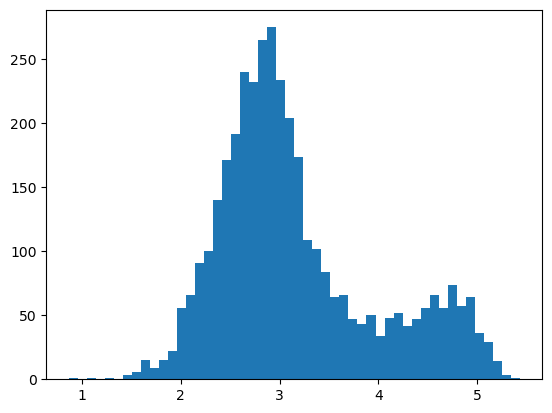

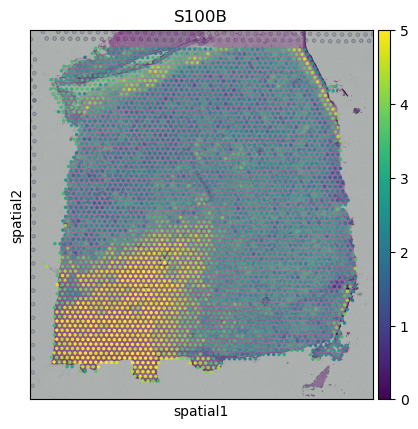

In [12]:
gene_name = "S100B"  # 替换为你要可视化的基因名
adata = super_adata[super_adata.obs['in_tissue']==1]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 绘制表达分布直方图
plt.hist(adata[:, gene_name].X.toarray().flatten(), bins=50)
plt.show()
# 绘制空间散点图
sc.pl.spatial(
    adata,
    color=gene_name,
    vmin=0,   # 最小值
    vmax=5,   # 最大值
    color_map="viridis"
)

/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


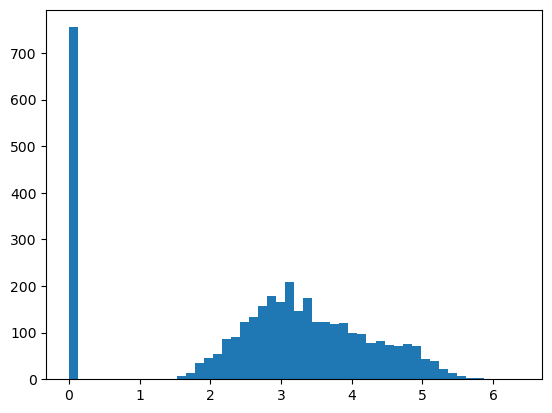

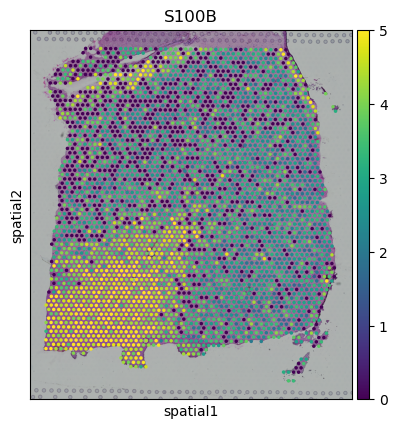

In [15]:
gene_name = "S100B"  # 替换为你要可视化的基因名
adata = raw_adata[raw_adata.obs['in_tissue']==1]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 绘制表达分布直方图
plt.hist(adata[:, gene_name].X.toarray().flatten(), bins=50)
plt.show()
# 绘制空间散点图
sc.pl.spatial(
    adata,
    color=gene_name,
    vmin=0,   # 最小值
    vmax=5,   # 最大值
    color_map="viridis"
)

In [5]:
import numpy as np

def compute_pcc_mse(matrix1, matrix2):
    
    n_genes = matrix1.shape[1]
    pcc_values = np.zeros(n_genes)
    mse_values = np.zeros(n_genes)
    
    for i in range(n_genes):
        col1 = matrix1[:, i].toarray().flatten()  # 转换为1D数组
        col2 = matrix2[:, i].toarray().flatten()
        
        # 计算PCC
        if np.std(col1) == 0 or np.std(col2) == 0:
            pcc_values[i] = np.nan  # 避免除零错误
        else:
            pcc_values[i], _ = pearsonr(col1, col2)

        # 计算MSE
        mse_values[i] = np.mean((col1 - col2) ** 2)

    return pcc_values, mse_values


pcc, mse = compute_pcc_mse(raw_adata.X, super_adata.X)

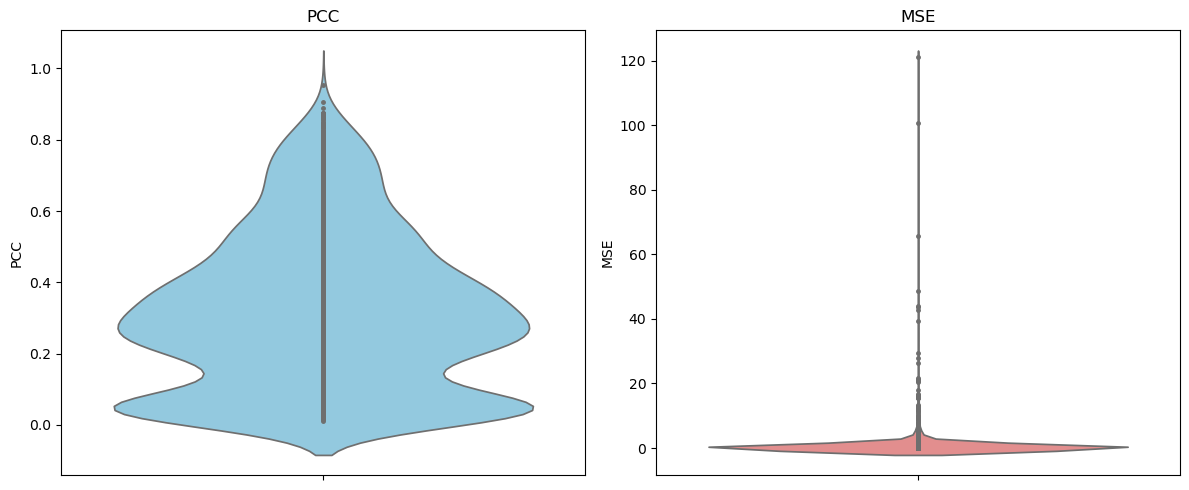

In [6]:
df = pd.DataFrame({
    "PCC": pcc,
    "MSE": mse
})

# 绘制小提琴图
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.violinplot(y=df["PCC"], ax=axes[0], inner="point", color="skyblue")
axes[0].set_title("PCC")
axes[0].set_ylabel("PCC")

sns.violinplot(y=df["MSE"], ax=axes[1], inner="point", color="lightcoral")
axes[1].set_title("MSE")
axes[1].set_ylabel("MSE")

plt.tight_layout()
plt.show()

In [7]:
np.mean(mse), np.mean(pcc)

(0.8493883052674057, 0.3156430040286308)